# Single Variate LSTM Model

To explore the computational performance of our model, I will investigate whether a univariate LSTM model would be appropriate. Essentially, we would model the pollution at future time steps based solely on historical pollution data.

We decided to explore this approach because, based on the correlation and lag data presented in our EDA, we hypothesize that pollution data—specifically from the previous time step—may be the most relevant predictor for our model. As we look into the scalability of our model, the goal is to reduce complexity to decrease computation time without sacrificing too much accuracy. Additionally, if we can eliminate irrelevant noise from the model, it will be highly beneficial.

In [37]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, Input
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time
import tensorflow as tf

In [38]:
df = pd.read_csv('LSTM-Multivariate_pollution.csv')
mapping = {
    'NE': 1,
    'SE': 2,
    'NW': 3,
    'cv': 4
}

df.wnd_dir = df.wnd_dir.map(mapping)

I will now scale the data and split into training and test data. We have decided on using a 90% split of data, and as it is time series data we will use the first 90% as training and last 10% as test.

In [39]:
df_scaled=df.copy()
scaler = MinMaxScaler()

df_scaled['date'] = pd.to_datetime(df_scaled['date'])

df_scaled.set_index('date', inplace=True)
    
columns = (['pollution'])
    
df_scaled = df_scaled[columns]
df_scaled[columns] = scaler.fit_transform(df_scaled[columns])


df_scaled.head()

,pollution
date,
2010-01-02 00:00:00,0.129779
2010-01-02 01:00:00,0.148893
2010-01-02 02:00:00,0.159960
2010-01-02 03:00:00,0.182093
2010-01-02 04:00:00,0.138833


In [40]:
train_size = int(len(df) * 0.9)  # 90% for training
train_data = df_scaled[:train_size]
test_data = df_scaled[train_size:]

print(f"Training data size: {train_data.shape}")
print(f"Test data size: {test_data.shape}")

Training data size: (39420, 1)
Test data size: (4380, 1)


## Moving window validation 
In LSTM models, regular cross-validation methods are not appropriate. This is because cross-validation assumes independence between data points, which does not hold for time series data. In time series models, past values are often highly relevant to predicting future values, as the data exhibits temporal dependencies. Additionally, with traditional cross-validation, there is a risk of data leakage. This occurs when the data is randomly split into training and testing sets, potentially allowing future information to influence the training process. This violates the temporal order of the data, where future values should not be used to predict past ones.

Hence we will use moving window validation instead, which ensures data used when making predictions is only from past data



In [41]:
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data.iloc[i:i+sequence_length].values)  # Sequence of pollution values
        labels.append(data.iloc[i + sequence_length])  # Next time step's pollution value (target)
    return np.array(sequences), np.array(labels)

X_train, y_train = create_sequences(train_data, 10)
X_test, y_test = create_sequences(test_data, 10)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (39410, 10, 1), y_train shape: (39410, 1)
X_test shape: (4370, 10, 1), y_test shape: (4370, 1)


In [42]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## Basic LSTM model

To start with we will use a large number of epochs of 100, and then look to implement early stopping to improve training time and reduce overfitting. The rest of the hyperparameters chosen are pretty standard when it comes to LSTM models which I will look at adjusting a few later on in relation to improving computation time and GPU performance. For instance batch size will be investigated, which is the number samples of data in a mini batch, which the model does a forward and backward pass on in each epoch. 

Throughout our testing of the models, we will evaluate performance based on both loss (training and validation loss, using mean squared error) and RMSE. Additionally, we will assess GPU performance and training time to draw conclusions about the impact of different modifications to the model.

In [43]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


This is due to looking at the hardware requirements for using GPUs on tensorflow on https://www.tensorflow.org/install/pip#windows-native we can see that there is "There is currently no official GPU support for MacOS". As I can not install tensorflow-metal, I will continue to conduct analysis using the version running on CPU, looking at the CPU performance.

Although I will only be looking at CPU training time, Matt who can use a GPU will test GPU performance using my final model.

Epoch 1/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0480 - val_loss: 6.5800e-04 - val_root_mean_squared_error: 0.0257
Epoch 2/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.7187e-04 - root_mean_squared_error: 0.0295 - val_loss: 5.2207e-04 - val_root_mean_squared_error: 0.0228
Epoch 3/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.8446e-04 - root_mean_squared_error: 0.0280 - val_loss: 5.1440e-04 - val_root_mean_squared_error: 0.0227
Epoch 4/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.6842e-04 - root_mean_squared_error: 0.0277 - val_loss: 5.1619e-04 - val_root_mean_squared_error: 0.0227
Epoch 5/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.6356e-04 - root_mean_squared_error: 0.0276 - val_loss: 5.1027e-04 - val_root_mean_squared_error: 0.0226
Epoch 6/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.6121e-04 - root_mean_squared_error: 0.0276 - val_loss: 5.0536e-04 - val_root_mean_squared_error: 0.0225
Ep

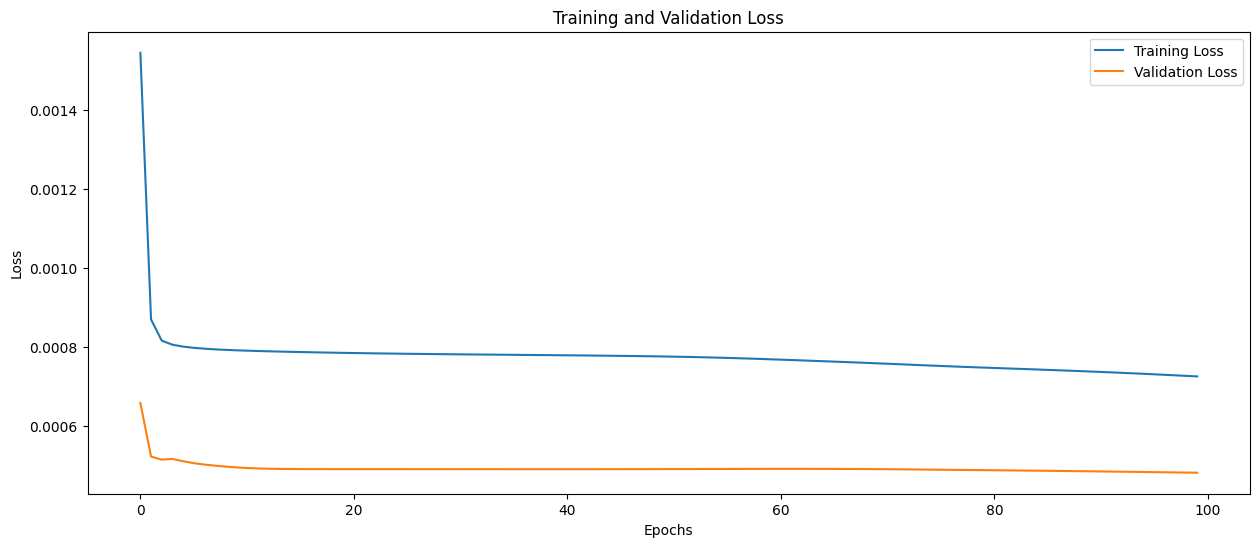

In [44]:
# Set random seed for reproducibility, same seed used in mulitvariate LSTM for comparison
tf.random.set_seed(7)


model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))  
model.add(LSTM(units=50, return_sequences=False)) #return_sequences = False used, common in time series prediction and non-stacked models
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[RootMeanSquaredError()])

initial_weights = model.get_weights()

start_time = time.time()

# Train the model
history = model.fit(
    X_train, y_train, 
    epochs=100,                  
    batch_size=64,                
    validation_data=(X_test, y_test)
)

# Output the training time
print("Training Time: ", time.time() - start_time)

# Plot training and validation loss over epochs
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()





## Early Stopping

Lets see if we can reduce overfitting and training time.

Epoch 1/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0018 - root_mean_squared_error: 0.0408 - val_loss: 5.7000e-04 - val_root_mean_squared_error: 0.0239
Epoch 2/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.0242e-04 - root_mean_squared_error: 0.0283 - val_loss: 5.1035e-04 - val_root_mean_squared_error: 0.0226
Epoch 3/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.6636e-04 - root_mean_squared_error: 0.0277 - val_loss: 4.9868e-04 - val_root_mean_squared_error: 0.0223
Epoch 4/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.6080e-04 - root_mean_squared_error: 0.0276 - val_loss: 4.9640e-04 - val_root_mean_squared_error: 0.0223
Epoch 5/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.5907e-04 - root_mean_squared_error: 0.0275 - val_loss: 4.9579e-04 - val_root_mean_squared_error: 0.0223
Epoch 6/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.5818e-04 - root_mean_squared_error: 0.0275 - val_loss: 4.9537e-04 - val_root_mean_squared_error: 0.0223
Ep

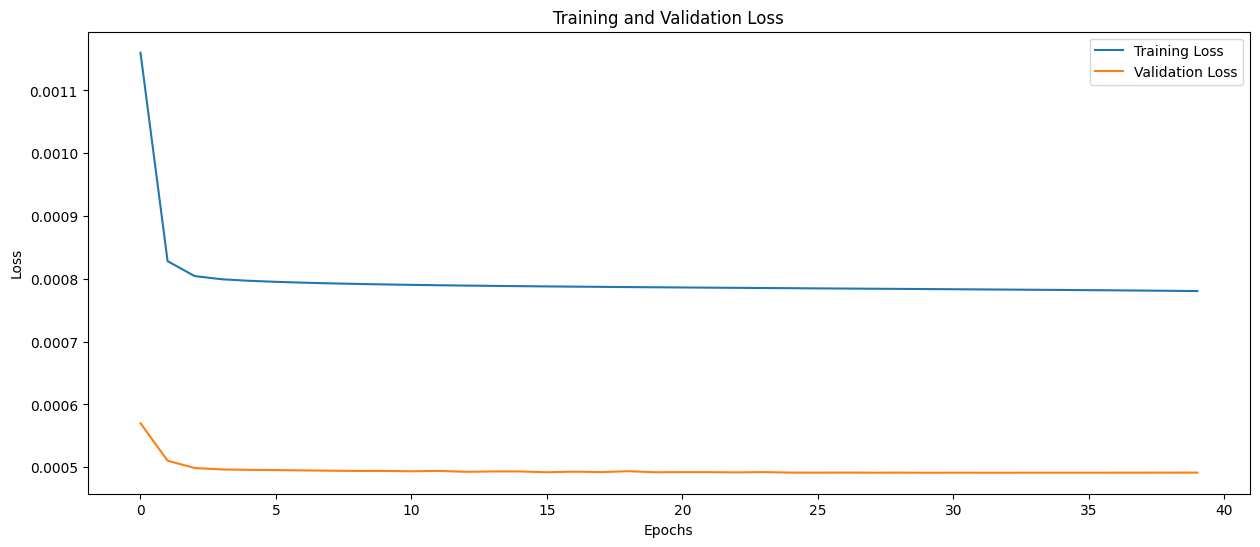

In [45]:
model.set_weights(initial_weights)

early_stopping = EarlyStopping(
    monitor='val_loss',          # Metric to monitor (could be 'val_accuracy', 'val_loss', etc.)
    patience=10,                 # Number of epochs to wait for improvement before stopping
    restore_best_weights=True,   # Restore the model with the best weights after training ends
    verbose=1                    # Print messages when early stopping is triggered
)

start_time = time.time() #time taken for model to run
# Train the model with early stopping
history = model.fit(
    X_train, y_train, 
    epochs=100,                   # Max number of epochs
    batch_size=64,                # Batch size
    validation_data=(X_test, y_test),  # Validation data for early stopping to monitor
     callbacks=[early_stopping]    # Pass the early stopping callback
)
print("Training Time: ", time.time() - start_time)

plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

As we can see, the number of optimal epochs is considered to be roughly to be 30, reducing the training time to 59 seconds from 146 seconds.

In [46]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Train Predictions': test_predictions,
                                  'Actual':y_test.flatten()})
print(test_results)

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
      Train Predictions    Actual
0              0.114937  0.101610
1              0.101946  0.111670
2              0.111815  0.110664
3              0.110531  0.134809
4              0.134513  0.170020
...                 ...       ...
4365           0.012444  0.008048
4366           0.010441  0.010060
4367           0.012540  0.010060
4368           0.012489  0.008048
4369           0.010431  0.012072

[4370 rows x 2 columns]


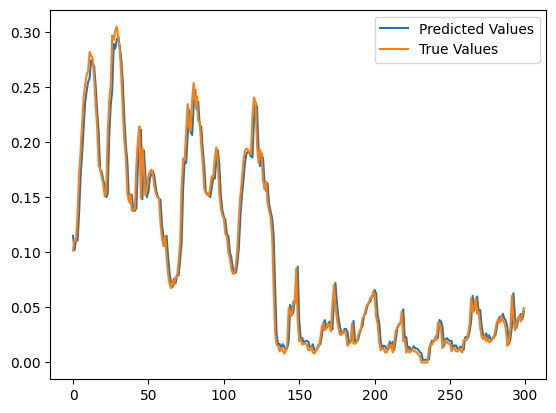

In [47]:
plt.plot(test_results['Train Predictions'][:300], label='Predicted Values')
plt.plot(test_results['Actual'][:300], label='True Values')
plt.legend()
plt.show()

In [48]:
rmse = sqrt(mse(y_test, test_predictions))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.02216


This is just a plot on the standardised values, lets have a look at the inverse and compare results on the actual scale.

   Train Predictions  Actual
0         114.247627   101.0
1         101.333885   111.0
2         111.144386   110.0
3         109.868149   134.0
4         133.706314   169.0


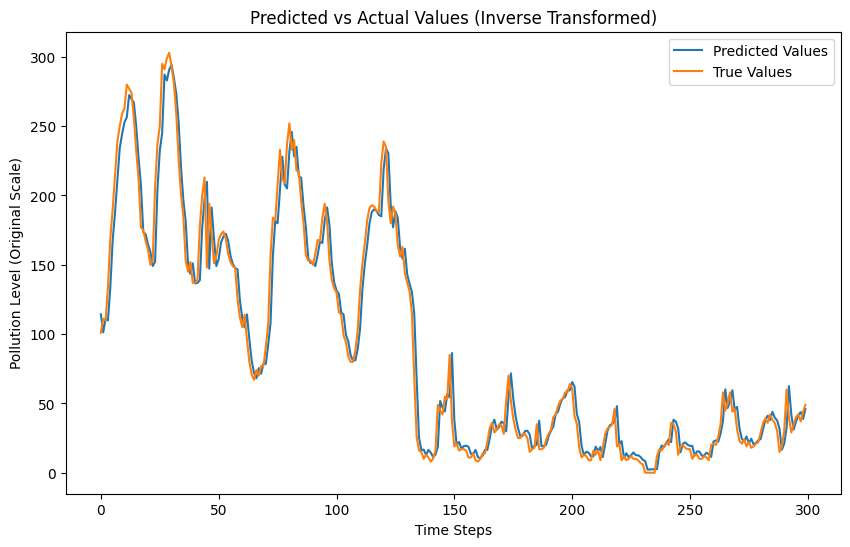

In [49]:
# Assume scaler is the same scaler used to normalize the data
# Reverse the scaling for both predictions and actual values

# Inverse transform for predicted values
test_predictions_scaled = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

# Inverse transform for actual values (y_test)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Create a DataFrame with actual vs predicted values
test_results = pd.DataFrame(data={'Train Predictions': test_predictions_scaled,
                                  'Actual': y_test_scaled})

# Print the results for a quick check
print(test_results.head())

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(test_results['Train Predictions'][:300], label='Predicted Values')
plt.plot(test_results['Actual'][:300], label='True Values')
plt.legend()
plt.title('Predicted vs Actual Values (Inverse Transformed)')
plt.xlabel('Time Steps')
plt.ylabel('Pollution Level (Original Scale)')
plt.show()


In [50]:
rmse = sqrt(mse(y_test_scaled, test_predictions_scaled))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 22.030


## Batch size

Taking the number of epochs needed to be roughly 20, we will now test batch size to identify optimal CPU performance agaibst root mean square error.

In [51]:
batch_sizes=[16,32,64,128,256]
results = {"batch_size": [], "rmse":[], "cpu_time": []}

In [52]:
for batch_size in batch_sizes:
        model.set_weights(initial_weights)
        start_time = time.time()
        model.fit(X_train, y_train, epochs=30, batch_size=batch_size, validation_data=(X_test, y_test), shuffle=False)
        cpu_time = time.time() - start_time
        CPU_scores = model.evaluate(X_test, y_test)
        results["batch_size"].append(batch_size)
        results["rmse"].append(CPU_scores[1])
        results["cpu_time"].append(cpu_time)




Epoch 1/30
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0014 - root_mean_squared_error: 0.0370 - val_loss: 5.4014e-04 - val_root_mean_squared_error: 0.0232
Epoch 2/30
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0010 - root_mean_squared_error: 0.0315 - val_loss: 5.4017e-04 - val_root_mean_squared_error: 0.0232
Epoch 3/30
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0010 - root_mean_squared_error: 0.0313 - val_loss: 5.4217e-04 - val_root_mean_squared_error: 0.0233
Epoch 4/30
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 9.9160e-04 - root_mean_squared_error: 0.0312 - val_loss: 5.4310e-04 - val_root_mean_squared_error: 0.0233
Epoch 5/30
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 9.8171e-04 - root_mean_squared_error: 0.0310 - val_loss: 5.4321e-04 - val_root_mean_squared_error: 0.0233
Epoch 6/30
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 9.7391e-04 - root_mean_squared_error: 0.0309 - val_loss: 5.4258e-04 - val_root_mean_squared_error: 0.0233
Epoc

Now we will use these results to compare batch size with training time and rsme 

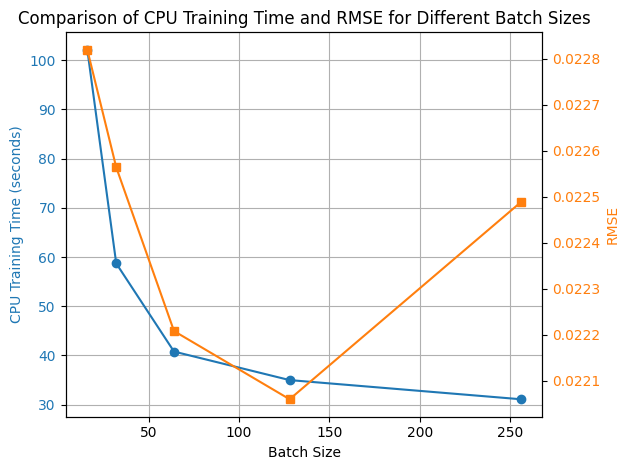

In [53]:
fig, ax1 = plt.subplots()

# Plot CPU training time
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('CPU Training Time (seconds)', color='tab:blue')
ax1.plot(results["batch_size"], results["cpu_time"], color='tab:blue', marker='o', label='CPU Training Time')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create second y-axis to plot RMSE
ax2 = ax1.twinx()
ax2.set_ylabel('RMSE', color='tab:orange')
ax2.plot(results["batch_size"], results["rmse"], color='tab:orange', marker='s', label='RMSE')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Show grid and title
plt.title('Comparison of CPU Training Time and RMSE for Different Batch Sizes')
ax1.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

As batch size 128 outputted the second best training time and best RMSE so we will use this batch size going forward. Any higher batch size will likely underfit the data set without having too much additional benefit to training time, as we can see with RSME increasing at 256 batch size.

## Dropout layer

We will explore the use of using a dropout layer in our model to prevent overfitting. Based on our current results, the data does not seem to be overfitting as our test rsme has been lower than our training rsme so far, and the compelxity of our model is much lower due to it being univariate. However this process is a common method in LSTM modelling, so I will explore the useful of it. 

A dropout layer is a regularization technique in neural networks, input and recurrent connections to LSTM units are probabilistically excluded from activation forcing the to learn new patterns and generalise better to unseen data.

In [54]:
model.set_weights(initial_weights)
model.add(Dropout(0.2))

start_time = time.time() 
history = model.fit(
    X_train, y_train, 
    epochs=30,                   
    batch_size=128,                
    validation_data=(X_test, y_test))

print("Training Time: ", time.time() - start_time)


Epoch 1/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0022 - root_mean_squared_error: 0.0457 - val_loss: 6.3472e-04 - val_root_mean_squared_error: 0.0252
Epoch 2/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.6728e-04 - root_mean_squared_error: 0.0294 - val_loss: 5.3737e-04 - val_root_mean_squared_error: 0.0232
Epoch 3/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.8874e-04 - root_mean_squared_error: 0.0281 - val_loss: 5.0898e-04 - val_root_mean_squared_error: 0.0226
Epoch 4/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.6817e-04 - root_mean_squared_error: 0.0277 - val_loss: 5.0099e-04 - val_root_mean_squared_error: 0.0224
Epoch 5/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.6138e-04 - root_mean_squared_error: 0.0276 - val_loss: 4.9789e-04 - val_root_mean_squared_error: 0.0223
Epoch 6/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.5817e-04 - root_mean_squared_error: 0.0275 - val_loss: 4.9628e-04 - val_root_mean_squared_error: 0.0223
Epoch 7/

In [55]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Train Predictions': test_predictions,
                                  'Actual':y_test.flatten()})
print(test_results)

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step
      Train Predictions    Actual
0              0.114099  0.101610
1              0.101073  0.111670
2              0.110687  0.110664
3              0.109696  0.134809
4              0.133402  0.170020
...                 ...       ...
4365           0.012805  0.008048
4366           0.010816  0.010060
4367           0.012828  0.010060
4368           0.012843  0.008048
4369           0.010789  0.012072

[4370 rows x 2 columns]


   Train Predictions  Actual
0         113.414673   101.0
1         100.466545   111.0
2         110.023064   110.0
3         109.038086   134.0
4         132.602020   169.0


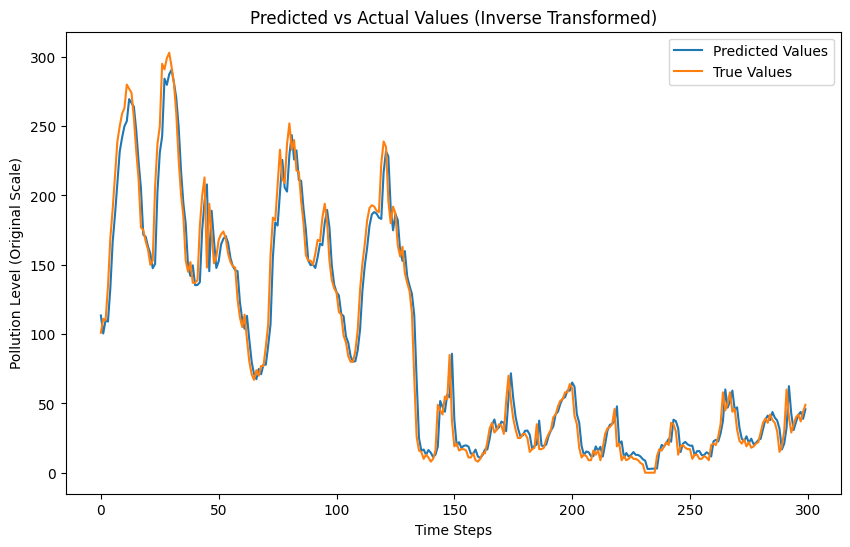

In [56]:
# Assume scaler is the same scaler used to normalize the data
# Reverse the scaling for both predictions and actual values

# Inverse transform for predicted values
test_predictions_scaled = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

# Inverse transform for actual values (y_test)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Create a DataFrame with actual vs predicted values
test_results = pd.DataFrame(data={'Train Predictions': test_predictions_scaled,
                                  'Actual': y_test_scaled})

# Print the results for a quick check
print(test_results.head())

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(test_results['Train Predictions'][:300], label='Predicted Values')
plt.plot(test_results['Actual'][:300], label='True Values')
plt.legend()
plt.title('Predicted vs Actual Values (Inverse Transformed)')
plt.xlabel('Time Steps')
plt.ylabel('Pollution Level (Original Scale)')
plt.show()


In [57]:
rmse = sqrt(mse(y_test, test_predictions))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.02220


In [58]:
rmse = sqrt(mse(y_test_scaled, test_predictions_scaled))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 22.069


The Dropout layer slightly increased our test RSME loss, indicating perhaps that the model was not overfitting.

We have a low test RMSE of 22.069 and training time of 34 seconds.

## Stacked LSTM

Epoch 1/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0044 - root_mean_squared_error: 0.0644 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 2/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - root_mean_squared_error: 0.0383 - val_loss: 7.7247e-04 - val_root_mean_squared_error: 0.0278
Epoch 3/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0011 - root_mean_squared_error: 0.0327 - val_loss: 6.0541e-04 - val_root_mean_squared_error: 0.0246
Epoch 4/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.0131e-04 - root_mean_squared_error: 0.0300 - val_loss: 5.4951e-04 - val_root_mean_squared_error: 0.0234
Epoch 5/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.5195e-04 - root_mean_squared_error: 0.0292 - val_loss: 5.3984e-04 - val_root_mean_squared_error: 0.0232
Epoch 6/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.3788e-04 - root_mean_squared_error: 0.0289 - val_loss: 5.2552e-04 - val_root_mean_squared_error: 0.0229
Epoch 7/30
308/308 ━

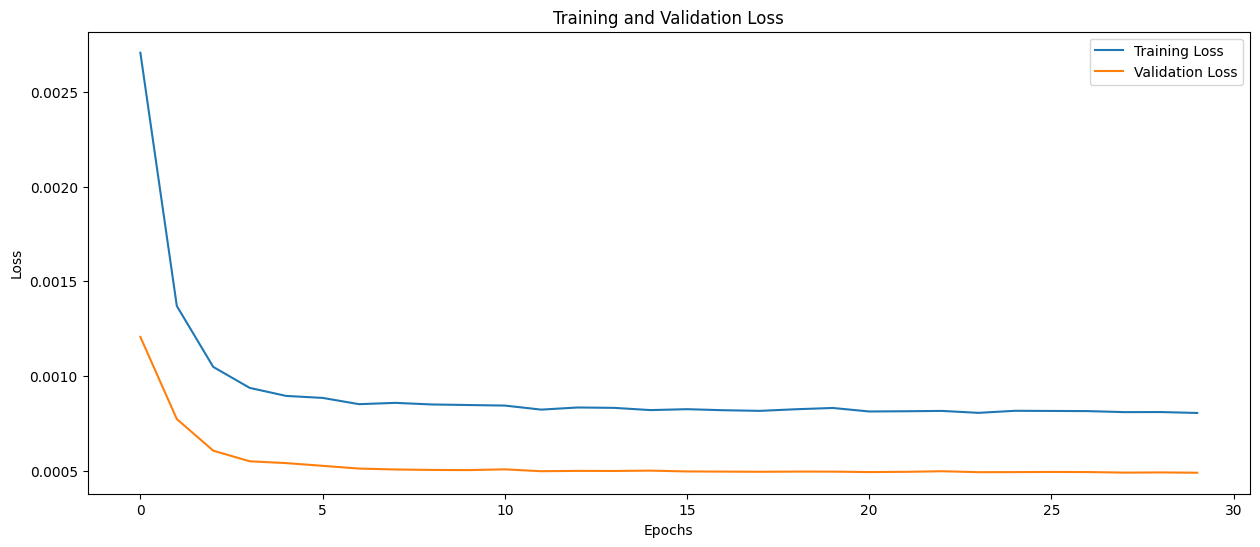

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
   Train Predictions  Actual
0         113.414673   101.0
1         100.466545   111.0
2         110.023064   110.0
3         109.038086   134.0
4         132.602020   169.0


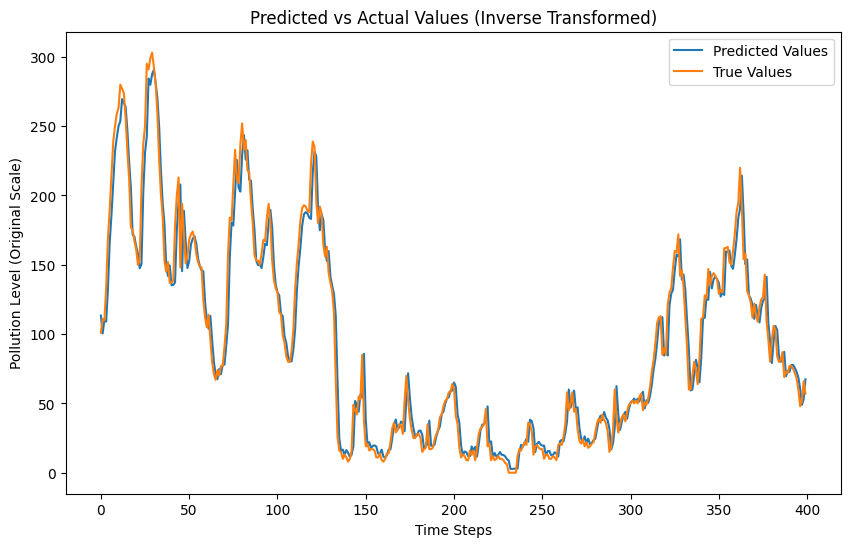

In [59]:
stacked_LSTM = Sequential()
stacked_LSTM.add(Input(shape =(X_train.shape[1], 1)))
stacked_LSTM.add(LSTM(32,return_sequences=True))
stacked_LSTM.add(Dropout(0.2)) 
stacked_LSTM.add(LSTM(16, return_sequences=False))
stacked_LSTM.add(Dense(1)) 

stacked_LSTM.compile(optimizer=Adam(learning_rate = 0.001), loss='mse', metrics = [RootMeanSquaredError()])

start_time = time.time()

history = stacked_LSTM.fit(
    X_train, y_train, 
    epochs=30,                  
    batch_size=128,                
    validation_data=(X_test, y_test)
)

print("Training Time: ", time.time() - start_time)

plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Train Predictions': test_predictions,
                                  'Actual':y_test.flatten()})

test_predictions_scaled = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

# Inverse transform for actual values (y_test)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Create a DataFrame with actual vs predicted values
test_results = pd.DataFrame(data={'Train Predictions': test_predictions_scaled,
                                  'Actual': y_test_scaled})

# Print the results for a quick check
print(test_results.head())

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(test_results['Train Predictions'][:400], label='Predicted Values')
plt.plot(test_results['Actual'][:400], label='True Values')
plt.legend()
plt.title('Predicted vs Actual Values (Inverse Transformed)')
plt.xlabel('Time Steps')
plt.ylabel('Pollution Level (Original Scale)')
plt.show()


In [60]:
rmse = sqrt(mse(y_test_scaled, test_predictions_scaled))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 22.069


Running a stacked model only increased training time whilst the RSME remained the same. I discuss why this may be the case in my conclusion.

## Conclusion 

In this notebook, I have explored the use of a single-variate LSTM model to assess whether we can reduce computational costs without sacrificing model performance. The results so far are very good, with the model performing well and achieving a low runtime, despite the lack of GPU support. This is encouraging for the scalability of our model, especially when considering larger datasets. When comparing the single-variate model with the multivariate model in future work, we will assess whether the dimensionality reduction was appropriate by identifying and potentially removing unnecessary noise.

In Matt's notebook, we will further evaluate how the LSTM model compares to the multivariate approach using the GPU support available through `tensorflow-metal`.

One of the key disadvantages of using LSTM models is their sequential nature, where each epoch is processed one at a time, limiting the potential for parallelization. For example, PySpark is not optimized for deep learning tasks, and therefore may not be well-suited for scaling our LSTM model. However, strategies such as minimizing the number of epochs, ensuring minimal training loss, and using large batch sizes (while avoiding overfitting) are essential for reducing training time, which were all used in this notebook.

Based on our EDA on partial autocorrelation, it suggested that only the previous time step is useful information to predict future values. So, when we used a stacked LSTM the one with more layers with the one that seemed to have same performance but its training time was higher, this could be just because we are adding unnecessary complexity on top of the model. The additional layers are made to capture long-range dependencies and complexity which may be unnecessary for this simple univariate data that doesn't seem to have long-range dependencies. Moreover, having `return_sequences=True` on the LSTM layers are not necessary, since it would keep all the hidden states. If the predictions only require the previous time step, this could slow down training and increase memory usage.

For my model, adding complexity to the model for better loss performance may not be ideal but this might be useful for Matt with his multivariate model.


On the contray, the model also appears to have some bias toward the mean (when looking at the extreme values of the graphs), which could be a sign of underfitting. This could be problematic when applying the model in the real world, as predicting high levels of pollution is crucial for prevention, rather than having an overly conservative model. This mean-bias could be due to a number of factors. Perhaps because we only have one feature, the model doesn't have enough data to capture the temporal dependencies, or there is a lack of variability or patterns available in the data. If we were to use only pollution data and no other metrics, one approach could be to include lag features (thus making the model multivariate). Another consideration could be adjusting the sequence length to be longer, e.g a day/24 hours. While this may seem counterintuitive based on our EDA of partial autocorrelation, it could allow the model to capture a longer range of temporal dependencies which may have been missed. This suggestion is supported by the EDA on autocorrelation instead, which had correlation of around 0.5 on time step t + 24. Also, adjusting the loss function from the mean squared error (which minimizes distance from the mean) to any other loss function could potentially solve the problem of model biasing towards the mean. In the pursuit of reducing training time, increasing the batch size might have had a negative effect with regard to underfitting.






### Other Resources



Moving window validation: https://medium.com/@TheDataScience-ProF/understanding-timeseriessplit-cross-validation-for-time-series-data-4c232cc4f844#:~:text=TimeSeriesSplit%20Cross%2DValidation%20Overview&text=The%20dataset%20is%20split%20into,and%20evaluated%20on%20future%20data.

considerations for optimising lstm performance: https://medium.com/@yousufdata/6-tips-to-tweak-your-lstm-bilstm-15fd02685c8#:~:text=Your%20LSTM%20should%20always%20have,error%20in%20your%20neural%20network.

considerations for optimising training time: https://towardsdatascience.com/how-to-reduce-the-training-time-of-your-neural-network-from-hours-to-minutes-fe7533a3eec5

pyspark suitability for lstm: https://datascience.stackexchange.com/questions/53089/how-to-implement-lstm-with-spark

return_sequences : https://eitca.org/artificial-intelligence/eitc-ai-tff-tensorflow-fundamentals/natural-language-processing-with-tensorflow/long-short-term-memory-for-nlp/examination-review-long-short-term-memory-for-nlp/what-is-the-significance-of-setting-the-return_sequences-parameter-to-true-when-stacking-multiple-lstm-layers/